In [3]:
import numpy as np
import pyglet

In [2]:
class ArmEnv(object):
    viewer = None
    dt = 0.1    # refresh rate
    action_bound = [-1, 1]
    goal = {'x': 100., 'y': 100., 'l': 25}
    state_dim = 2
    action_dim = 2

    def __init__(self):
        self.arm_info = np.zeros(
            2, dtype=[('l', np.float32), ('r', np.float32)])
        self.arm_info['l'] = 100
        self.arm_info['r'] = np.pi/6

    def step(self, action):
        done = False
        r = 0.
        action = np.clip(action, *self.action_bound)
        self.arm_info['r'] += action * self.dt
        self.arm_info['r'] %= np.pi * 2    # normalize

        # state
        s = self.arm_info['r']

        (a1l, a2l) = self.arm_info['l']  # radius, arm length
        (a1r, a2r) = self.arm_info['r']  # radian, angle
        a1xy = np.array([200., 200.])    # a1 start (x0, y0)
        a1xy_ = np.array([np.cos(a1r), np.sin(a1r)]) * a1l + a1xy  # a1 end and a2 start (x1, y1)
        finger = np.array([np.cos(a1r + a2r), np.sin(a1r + a2r)]) * a2l + a1xy_  # a2 end (x2, y2)

        # done and reward
        if (self.goal['x'] - self.goal['l']/2 < finger[0] < self.goal['x'] + self.goal['l']/2
        ) and (self.goal['y'] - self.goal['l']/2 < finger[1] < self.goal['y'] + self.goal['l']/2):
                done = True
                r = 1. # Sparse reward
        return s, r, done
    
    def reset(self):
        self.arm_info['r'] = 2 * np.pi * np.random.rand(2)
        return self.arm_info['r']

    def render(self):
        if self.viewer is None:
            self.viewer = Viewer(self.arm_info, self.goal)
        self.viewer.render()

    def sample_action(self):
        return np.random.rand(2)-0.5    # two radians

In [3]:
class Viewer(pyglet.window.Window):
    bar_thc = 5
    w0 = 25   # Object width
    wp = 5.0  # 
    fw = 1.8  # Finger width
    
    d2 = 5.0  # distance from x-axis to right bottom of the object 
    t2 = np.pi / 2
    t1 = np.pi / 2
    d1 = 6.2 # distance from x-axis to left bottom of the object
    def __init__(self, arm_info, goal):
        # vsync=False to not use the monitor FPS, we can speed up training
        super(Viewer, self).__init__(width=400, height=400, resizable=False, caption='Arm', vsync=False)
        pyglet.gl.glClearColor(1, 1, 1, 1)
        self.arm_info = arm_info
        self.center_coord = np.array([200, 200])
        
        self.obj_pos = translateLeft(self.t2, self.d2)
        self.batch = pyglet.graphics.Batch()    # display whole batch at once
        """
        self.goal = self.batch.add(
            4, pyglet.gl.GL_QUADS, None,    # 4 corners
            ('v2f', [goal['x'] - goal['l'] / 2, goal['y'] - goal['l'] / 2,                # location
                     goal['x'] - goal['l'] / 2, goal['y'] + goal['l'] / 2,
                     goal['x'] + goal['l'] / 2, goal['y'] + goal['l'] / 2,
                     goal['x'] + goal['l'] / 2, goal['y'] - goal['l'] / 2]),
            ('c3B', (86, 109, 249) * 4))    # color
        """
        self.goal = self.batch.add(
            4, pyglet.gl.GL_QUADS, None,    # 4 corners
            ('v2f', [self.obj_pos[0][0], self.obj_pos[0][1]         # location
                     self.obj_pos[1][0], self.obj_pos[1][1],
                     self.obj_pos[2][0], self.obj_pos[2][1],
                     self.obj_pos[3][0], self.obj_pos[3][1]),
            ('c3B', (86, 109, 249) * 4))    # color
        
        self.arm1 = self.batch.add(
            4, pyglet.gl.GL_QUADS, None,
            ('v2f', [250, 250,                # location
                     250, 300,
                     260, 300,
                     260, 250]),
            ('c3B', (249, 86, 86) * 4,))    # color
        self.arm2 = self.batch.add(
            4, pyglet.gl.GL_QUADS, None,
            ('v2f', [100, 150,              # location
                     100, 160,
                     200, 160,
                     200, 150]), ('c3B', (249, 86, 86) * 4,))
        
    def translateLeft(t2, d2):
        
        # Transformation Matrix
        x_square = self.wp + (d2 + w0 / 2.) * np.cos(np.float64(t2)) - (self.fw + self.w0 / 2.) * np.sin(np.float64(t2))
        y_square = (d2 + w0 / 2.) * np.sin(np.float64(t2)) + (self.fw + self.w0 / 2.) * np.cos(np.float64(t2))

        pts = np.array([[-self.w0 / 2., -self.w0 / 2., self.w0 / 2., self.w0 / 2.], [-self.w0 / 2., self.w0 / 2., self.w0 / 2., -self.w0 / 2.], [1, 1, 1, 1]])
        R = np.array([[np.cos(t2), -np.sin(t2), x_square], [np.sin(t2), np.cos(t2), y_square], [0, 0, 1]])

        # Points after transformation
        pts_new = np.dot(R, pts)
        
        # Plotting the Object
        pts = np.transpose([[pts_new[0, :]], [pts_new[1, :]]])
        pts = pts.reshape((4, 2))
        return pts

    def render(self):
        self._update_arm()
        self.switch_to()
        self.dispatch_events()
        self.dispatch_event('on_draw')
        self.flip()

    def on_draw(self):
        self.clear()
        self.batch.draw()

    def _update_arm(self):
        (a1l, a2l) = self.arm_info['l']     # radius, arm length
        (a1r, a2r) = self.arm_info['r']     # radian, angle
        a1xy = self.center_coord            # a1 start (x0, y0)
        a1xy_ = np.array([np.cos(a1r), np.sin(a1r)]) * a1l + a1xy   # a1 end and a2 start (x1, y1)
        a2xy_ = np.array([np.cos(a1r+a2r), np.sin(a1r+a2r)]) * a2l + a1xy_  # a2 end (x2, y2)

        a1tr, a2tr = np.pi / 2 - self.arm_info['r'][0], np.pi / 2 - self.arm_info['r'].sum()
        xy01 = a1xy + np.array([-np.cos(a1tr), np.sin(a1tr)]) * self.bar_thc
        xy02 = a1xy + np.array([np.cos(a1tr), -np.sin(a1tr)]) * self.bar_thc
        xy11 = a1xy_ + np.array([np.cos(a1tr), -np.sin(a1tr)]) * self.bar_thc
        xy12 = a1xy_ + np.array([-np.cos(a1tr), np.sin(a1tr)]) * self.bar_thc

        xy11_ = a1xy_ + np.array([np.cos(a2tr), -np.sin(a2tr)]) * self.bar_thc
        xy12_ = a1xy_ + np.array([-np.cos(a2tr), np.sin(a2tr)]) * self.bar_thc
        xy21 = a2xy_ + np.array([-np.cos(a2tr), np.sin(a2tr)]) * self.bar_thc
        xy22 = a2xy_ + np.array([np.cos(a2tr), -np.sin(a2tr)]) * self.bar_thc

        self.arm1.vertices = np.concatenate((xy01, xy02, xy11, xy12))
        self.arm2.vertices = np.concatenate((xy11_, xy12_, xy21, xy22))


SyntaxError: invalid syntax (<ipython-input-3-e44e4d50dbe3>, line 32)

In [4]:
if __name__ == '__main__':
    env = ArmEnv()
    while True:
        env.render()
        #env.step(env.sample_action())

NameError: name 'Viewer' is not defined

In [7]:
for i in range(5):
    print(np.random.rand(1)-0.5)

[0.03341629]
[0.16985617]
[-0.36436752]
[-0.06954137]
[0.20358685]


In [6]:
action = np.random.rand(2)
print("action : ", action)

action = action - 0.5
print("action : ", action)

action :  [0.63924866 0.39260701]
action :  [ 0.13924866 -0.10739299]


In [3]:
action_bound = [-1, 1]
dt = 0.1


In [8]:
arm_info = np.zeros(3, dtype=[('l', np.float32), ('r', np.float32)])
arm_info

array([(0., 0.), (0., 0.), (0., 0.)], dtype=[('l', '<f4'), ('r', '<f4')])

In [14]:
arm_info['l'] = 100
arm_info['r'] = np.pi/6
arm_info

array([(100., 0.5235988), (100., 0.5235988), (100., 0.5235988)],
      dtype=[('l', '<f4'), ('r', '<f4')])

In [21]:
action_ = np.random.rand(1)
action_
print(action_)
action_bound = [-1, 1]
action_ = action_-0.5
print("action : ", action)

[0.55198386]
action :  [-0.05706867]


In [22]:
action_ = np.clip(action_, *action_bound)
action_

array([0.05198386])

In [77]:
ff_info = np.zeros(2, dtype=[('d', np.float32), ('t', np.float32), ('a', np.int)] )
print(ff_info)
ff_info['t'] = np.pi/2
ff_info['d'] = 62
print(ff_info)
print(ff_info['d'][0])

[(0., 0., 0) (0., 0., 0)]
[(62., 1.5707964, 0) (62., 1.5707964, 0)]
62.0


In [5]:
class ff_env(object):

    
    d2 = 50  # distance from x-axis to right bottom of the object 
    t2 = np.pi / 2 
    t1 = np.pi / 2
    d1 = 62 # distance from x-axis to left bottom of the object
    
    def __init__(self):
        self.action_bound = [-1, 1]
        self.ff_info = np.zeros(2, dtype=[('f', np.float32), ('t', np.float32)] )
        self.ff_info['t'] = np.pi/2
        self.ff_info['d'] = 0
        
        self.w0 = 25   # Object width
        self.wp = 50  # 
        self.fw = 18  # Finger width
    
    def reset(self):
        self.ff_info['t'] = np.pi/2
        
    def sample_action(self):
        return np.random.rand(1)-0.5
    
    def translateLeft_obj(self,t2, d2):
        
        # Transformation Matrix
        x_square = self.wp + (d2 + self.w0 / 2.) * np.cos(np.float64(t2)) - (self.fw + self.w0 / 2.) * np.sin(np.float64(t2)) 
        y_square = (d2 + self.w0 / 2.) * np.sin(np.float64(t2)) + (self.fw + self.w0 / 2.) * np.cos(np.float64(t2))

        pts = np.array([[-self.w0 / 2., -self.w0 / 2., self.w0 / 2., self.w0 / 2.], [-self.w0 / 2., self.w0 / 2., self.w0 / 2., -self.w0 / 2.], [1, 1, 1, 1]])
        R = np.array([[np.cos(t2), -np.sin(t2), x_square], [np.sin(t2), np.cos(t2), y_square], [0, 0, 1]])

        # Points after transformation
        pts_new = np.dot(R, pts)
        
        # Plotting the Object
        pts = np.transpose([[pts_new[0, :]], [pts_new[1, :]]])
        pts = pts.reshape((4, 2))
        """
        print(pts[1][0],pts[1][1], '\n',        # location
              pts[0][0],pts[0][1], '\n',
              pts[3][0],pts[3][1], '\n',
              pts[2][0],pts[2][1]) 
        """
        return pts*2.5

    def translateLeft_fingers(self,t2, d2):

        # Calculate theta2, d2
        d2v = np.array([d2 * np.cos(np.float64(t2)), d2 * np.sin(np.float64(t2))])
        w0v = np.array([self.w0 * np.sin(np.float64(t2)), -self.w0 * np.cos(np.float64(t2))])
        wpv = np.array([self.wp, 0.])
        f1v = np.array([self.fw * np.sin(np.float64(t2)), -self.fw * np.cos(np.float64(t2))])
        av = d2v - f1v - w0v + wpv
        # Calculated Values of theta1, d1
        d1 = np.sqrt(float((av * av).sum() - self.fw * self.fw))
        t1 = np.arctan2(float(av[1]), float(av[0])) + np.arctan2(self.fw, d1)

        l_fw_pts = np.array([[0., 0., self.fw, self.fw], [40, 130, 130, 40], [1.0, 1.0, 1.0, 1.0]])
        r_fw_pts = np.array([[0., 0., -self.fw, -self.fw], [40, 130, 130, 40], [1.0, 1.0, 1.0, 1.0]])
        # Transformation matrices for the finger width
        R_fw1 = [[np.cos(t1 - np.pi / 2.0), -np.sin(t1 - np.pi / 2), 0.0], [np.sin(t1 - np.pi / 2), np.cos(t1 - np.pi / 2), 0.0], [0.0, 0.0, 1.0]]
        R_fw2 = [[np.cos(t2 - np.pi / 2), -np.sin(t2 - np.pi / 2), self.wp], [np.sin(t2 - np.pi / 2), np.cos(t2 - np.pi / 2), 0.0], [0.0, 0.0, 1.0]]

        # finger Coordinates 1-> Left, 2-> Right
        pts_fw1 = np.dot(R_fw1, l_fw_pts)
        pts_fw2 = np.dot(R_fw2, r_fw_pts)

        # Plotting the fingers
        fw_1 = np.transpose([[pts_fw1[0, :]], [pts_fw1[1, :]]]).reshape((4, 2))
        fw_2 = np.transpose([[pts_fw2[0, :]], [pts_fw2[1, :]]]).reshape((4, 2))
        #print("fw_1 :", fw_1)
        #print("fw_2 :", fw_2)
        return fw_1*2.5, fw_2*2.5
    

In [6]:
ffenv = ff_env()

d2 = 50  # distance from x-axis to right bottom of the object 
t2 = np.pi / 2 
t1 = np.pi / 2
d1 = 62 # distance from x-axis to left bottom of the object

dt = 0.1


print(ffenv.ff_info)

obj_pos = ffenv.translateLeft_obj(t2, d2)
print("obj_pos : ", obj_pos)
finger_l, finger_r = ffenv.translateLeft_fingers(t2, d2)
print("finger_l : ", finger_l)
print("finger_r : ", finger_r)

"""
print('---------------')
for i in range(10):
    action = ffenv.sample_action()
    print(action)
    action = np.clip(action, *action_bound)
    print("clipped action : ", action)
    print("t2 initial : ", t2)
    t2 += action * dt
    print("t2 changed : ", t2)
    obj_pos = ffenv.translateLeft_obj(t2, d2)
    print("obj_pos : ", obj_pos)
    finger_l, finger_r = ffenv.translateLeft_fingers(t2, d2)
    print("finger_l : ", finger_l)
    print("finger_r : ", finger_r)
"""

[(0., 1.5707964) (0., 1.5707964)]
obj_pos :  [[ 80.  125. ]
 [ 17.5 125. ]
 [ 17.5 187.5]
 [ 80.  187.5]]
finger_l :  [[-22.35428248  97.46941087]
 [-72.65141806 316.77558532]
 [-28.79018316 326.83501243]
 [ 21.50695241 107.52883798]]
finger_r :  [[125. 100.]
 [125. 325.]
 [ 80. 325.]
 [ 80. 100.]]


'\nprint(\'---------------\')\nfor i in range(10):\n    action = ffenv.sample_action()\n    print(action)\n    action = np.clip(action, *action_bound)\n    print("clipped action : ", action)\n    print("t2 initial : ", t2)\n    t2 += action * dt\n    print("t2 changed : ", t2)\n    obj_pos = ffenv.translateLeft_obj(t2, d2)\n    print("obj_pos : ", obj_pos)\n    finger_l, finger_r = ffenv.translateLeft_fingers(t2, d2)\n    print("finger_l : ", finger_l)\n    print("finger_r : ", finger_r)\n'

In [7]:
obj_pos[1][0], obj_pos[1][1], obj_pos[0][0]

(17.500000000000018, 125.0, 80.00000000000001)

In [16]:
w0 = 25   # Object width
wp = 50  # 
fw = 18  # Finger width

d2 = 50  # distance from x-axis to right bottom of the object 
t2 = np.pi / 2 
t1 = np.pi / 2
d1 = 62 # distance from x-axis to left bottom of the object
def translateLeft_obj(t2, d2):

    # Transformation Matrix
    x_square = wp + (d2 + w0 / 2.) * np.cos(np.float64(t2)) - (fw + w0 / 2.) * np.sin(np.float64(t2)) 
    y_square = (d2 + w0 / 2.) * np.sin(np.float64(t2)) + (fw + w0 / 2.) * np.cos(np.float64(t2))

    pts = np.array([[-w0 / 2., -w0 / 2., w0 / 2., w0 / 2.], [-w0 / 2., w0 / 2., w0 / 2., -w0 / 2.], [1, 1, 1, 1]])
    R = np.array([[np.cos(t2), -np.sin(t2), x_square], [np.sin(t2), np.cos(t2), y_square], [0, 0, 1]])

    # Points after transformation
    pts_new = np.dot(R, pts)

    # Plotting the Object
    pts = np.transpose([[pts_new[0, :]], [pts_new[1, :]]])
    pts = pts.reshape((4, 2))
    """    print(pts[1][0],pts[1][1], '\n',        # location
          pts[0][0],pts[0][1], '\n',
          pts[3][0],pts[3][1], '\n',
          pts[2][0],pts[2][1]) 
    """
    return pts*2.5

In [19]:
obj_pos_ = translateLeft_obj(np.pi/2, d2 =50)
print(obj_pos_)

[[ 80.  125. ]
 [ 17.5 125. ]
 [ 17.5 187.5]
 [ 80.  187.5]]


In [25]:
np.hstack([obj_pos_[1][0], obj_pos_[1][1]]) 

array([ 17.5, 125. ])

In [20]:
object = np.concatenate((obj_pos_[1][0], obj_pos_[1][1],         
                         obj_pos_[0][0], obj_pos_[0][1],
                         obj_pos_[3][0], obj_pos_[3][1],
                         obj_pos_[2][0], obj_pos_[2][1]))

ValueError: zero-dimensional arrays cannot be concatenated

In [26]:
np.pi

3.141592653589793

Limitations for the finger rotation 

40 deg : 0.698132 rad

140 deg : 2.443 rad

# Dual Action 

1. Complete generalising the environemnt for both the actions

Select a random action between 0 and 1 (delta_theta_left and delta_theta_right)

Create a common function for getting object positions, finger_right positions and finger_left positions based on action is delta theta_1 (or) delta tehta_2.  


In [3]:
import random
import numpy as np
list_ = [0, 1]
for i in range(5):
    list_i = random.choice(list_) 
    print(list_i) # Use this for randomly selecting the theta_l or tehta_r

0
0
1
0
0


In [20]:
for i in range(10):
    action = np.random.rand(2) - 0.5 # Use this for selecting the magnitude of change in tehta_l or theta_r
    print(action) 

[ 0.0414578  -0.46192004]
[0.08062443 0.24403946]
[ 0.19787908 -0.12080952]
[ 0.46838361 -0.18004187]
[-0.49817844  0.02291308]
[-0.01931393 -0.38057104]
[0.18442163 0.24884824]
[-0.19903249 -0.02340453]
[-0.09133922  0.00117175]
[0.13932665 0.30849224]


In [5]:
list_ = [0, 1]
list_i = random.choice(list_) 
action_i = np.random.rand(1) - 0.5
action = np.random.rand(2)
if (list_i == 0):
    action[0] = action_i
    action[1] = 0
else:
    action[0] = 0
    action[1] = action_i

print(action)

[0.20258222 0.        ]


In [16]:
# Action[0]
if (action[0] != 0 and action[1] == 0):
    print("Aciton is sliding left")

Aciton is sliding left


In [14]:
def take_action():
    list_ = [0, 1]
    list_i = random.choice(list_) 
    action_i = np.random.rand(1) - 0.5
    action = np.random.rand(2)
    if (list_i == 0):
        action[0] = action_i
        action[1] = 0
    else:
        action[0] = 0
        action[1] = action_i

    print(action)
for i in range(10):
    take_action()
    

[ 0.         -0.21584845]
[0.         0.25775574]
[-0.17061405  0.        ]
[0.05357847 0.        ]
[-0.45357418  0.        ]
[0.37080079 0.        ]
[ 0.         -0.32791881]
[ 0.         -0.39942426]
[ 0.         -0.11572681]
[0.         0.06745553]


In [6]:
if (action[0] == 0):
    print('left')
elif (action[1] == 0):
    print('right')

right


In [7]:
action

array([0.20258222, 0.        ])

In [8]:
action[1] == 0

True

# Fixing calc_right_config

In [1]:
import numpy as np
import pyglet
import random
import time
from pyglet.window import key
from math import radians, degrees

In [2]:
tl = degrees(100)
dl = 100
w0 = 25
wp = 50
fw = 18

In [3]:
d1v = np.array([dl * np.cos(tl), dl * np.sin(tl)])
print(d1v)

[ 77.31211771 -63.42583429]


In [4]:
w0v = np.array([w0 * np.sin(tl), w0 * np.cos(tl)])
print(w0v)

[-15.85645857  19.32802943]


In [5]:
wpv = np.array([wp, 0.])
print(wpv)

[50.  0.]


In [6]:
f1v = np.array([fw * np.sin(tl), fw * np.cos(tl)])
print(f1v)

[-11.41665017  13.91618119]


In [7]:
av = d1v + w0v + f1v - wpv
print(av)

[  0.03900897 -30.18162367]


In [8]:
dr = np.sqrt(float((av * av).sum() - fw * fw))
print(dr)

24.22667804724324


In [11]:
np.arctan2(float(av[1]), float(av[0])) 

-1.5695038534225954

In [12]:
np.arctan2(float(av[1]), float(av[0])) - np.arctan2(fw, dr)

-2.208498671350577

In [9]:
tr = np.arctan2(float(av[1]), float(av[0])) - np.arctan2(fw, dr)
print(tr)

-2.208498671350577


In [10]:
print("av :", av)
print("fw :", fw)
print("dr :", dr)

av : [  0.03900897 -30.18162367]
fw : 18
dr : 24.22667804724324


# Fix negative actions

In [34]:
import random 
import numpy as np
import matplotlib.pyplot as plt
list_ = [0, 1]
list_i = random.choice(list_) 
action_i = np.random.rand(1) - 0.5
action = np.random.rand(2)
if (list_i == 0):
    action[0] = action_i
    action[1] = 0
else:
    action[0] = 0
    action[1] = action_i

print(action)

[0.30209782 0.        ]


In [44]:
for i in range(10):
    action = np.random.rand(2) - 0.9 # Use this for selecting the magnitude of change in tehta_l or theta_r
    print(action) 

[-0.06346363 -0.41557861]
[-0.02558906 -0.32971497]
[-0.05091122 -0.10201371]
[-0.7022427  -0.67879989]
[-0.0653915 -0.7104958]
[-0.59817235 -0.00822872]
[-0.4690332  -0.24787626]
[-0.35176588 -0.30666973]
[-0.21819617 -0.85074031]
[-0.26761977 -0.35984928]


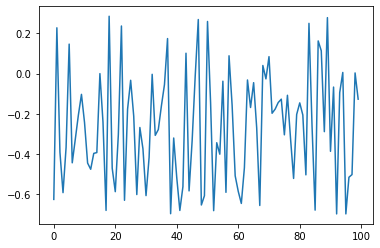

In [42]:
# Randomly sleecting an action and plotting the randomness
list_ = []
for i in range(100):
    list_.append(np.random.rand(1) - 0.7)
    # print( np.random.rand(1) )
#print(list_)
plt.plot(list_)
plt.show()

In [52]:
x = 5
y = 6
print(np.vstack([x, y])*2.5)

[[12.5]
 [15. ]]


In [50]:
obj_center = [x, y]
print(obj_center)

[5, 6]


In [56]:
obj_center*2.5

TypeError: can't multiply sequence by non-int of type 'float'

In [60]:
d = np.array([x, y])
print(d*2.5)

[12.5 15. ]


# Plot obj_loc

In [100]:
import matplotlib.pyplot as plt
a1 = np.array([1,1])
a2 = np.array([2,2])

In [101]:
a = np.append([a1], [a2], axis=0)
print(a)

[[1 1]
 [2 2]]


In [102]:
a3 = np.array([3,3])
a = np.append(a, [a3], axis= 0)
print(a)

[[1 1]
 [2 2]
 [3 3]]


In [103]:
a4 = np.array([4,4])
a = np.append(a, [a4], axis=0)
print(a)

[[1 1]
 [2 2]
 [3 3]
 [4 4]]


In [13]:
# Working on ff_env_2
from ff_env_2 import *

In [14]:
env = FFEnv()

Initial ff_info :  [(105.      , 1.5707964, 0) (103.682205, 1.4654704, 0)]


In [15]:
env.ff_info

array([(105.      , 1.5707964, 0), (103.682205, 1.4654704, 0)],
      dtype=[('d', '<f4'), ('t', '<f4'), ('a', '<i8')])

In [16]:
env.goal['x'], env.goal['y']

(100.0, 100.0)

In [26]:
env.IK_slide_right_f(50,100)

TypeError: cannot create mpf from t1_sol

# Designing a Function for selecting Goal Points 

In [141]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [143]:
# Randomly selecting X - Co-ordinates within limits
x_r = np.random.randint(-137.71, 243.11, size=50).astype("float64")
print('x_r : ', x_r)

# Randomly selecting Y - Co-ordinates within limits
y_r = np.random.randint(118.67, 284.80, size=50).astype("float64")
print('y_r : ', y_r)

x_r :  [ 215.  131. -114.   -4.   80.  105.  -43.  209.  -96.   13.   87.  106.
 -110.  157. -113.  -87.   17.  211.  104.   87.   30.  162.   36.  -12.
   -4.  126.   86.  125.  192.  202.    7.   11.   64.  -25.  105.   98.
   22.  -61.  -27.  139.  -34.  107.  128. -116. -109.  236.  109.  102.
  165.   97.]
y_r :  [239. 170. 222. 184. 240. 220. 263. 143. 153. 143. 216. 254. 171. 264.
 240. 156. 123. 278. 203. 197. 256. 176. 249. 256. 159. 230. 269. 162.
 277. 224. 283. 253. 214. 178. 197. 263. 257. 215. 273. 252. 232. 263.
 277. 124. 251. 258. 187. 212. 235. 270.]


In [268]:
# Defining Points from A - D 
D_x, D_y = (-137.71, 215.09)
E_x, E_y = (45.107, 284.509)
F_x, F_y = (76.249, 281.25)
A_x, A_y = (243.11, 210.22)
B_x, B_y = (112.96, 129.67)
C_x, C_y = (-22.80, 118.67)

# Splitting x and y
x = [A_x, B_x, C_x, D_x, E_x, F_x, A_x]
y = [A_y, B_y, C_y, D_y, E_y, F_y, A_y]
print(x, y)

[243.11, 112.96, -22.8, -137.71, 45.107, 76.249, 243.11] [210.22, 129.67, 118.67, 215.09, 284.509, 281.25, 210.22]


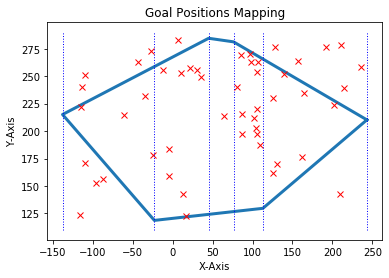

In [269]:
# Plotting all the points from A-E
# And Dividing the whole plotting into 6 sections

# Plotting lines acros points
plt.plot(x, y, linewidth=3)

# Plotting a scatter points 
plt.plot(x_r, y_r, 'x', color='red')

# Plotting Section line-1 across point D 
plt.plot([D_x, D_x], [110, 290], linestyle='dotted', linewidth=1, color='blue')

# Plotting Section line-2 across point C
plt.plot([C_x, C_x], [110, 290], linestyle='dotted', linewidth=1, color='blue')

# Plotting Section line-3 across point E
plt.plot([E_x, E_x], [110, 290], linestyle='dotted', linewidth=1, color='blue')

# Plotting Section line-4 across point F
plt.plot([F_x, F_x], [110, 290], linestyle='dotted', linewidth=1, color='blue')

# Plotting Section line-5 across point B
plt.plot([B_x, B_x], [110, 290], linestyle='dotted', linewidth=1, color='blue')

# Plotting Section line-6 across point A
plt.plot([A_x, A_x], [110, 290], linestyle='dotted', linewidth=1, color='blue')

# Set title 1
plt.title("Goal Positions Mapping")

# Set X-label
plt.xlabel("X-Axis", fontsize=10)

# Set Y-label
plt.ylabel("Y-Axis", fontsize=10)

# Display plot
plt.show()

In [199]:
def check_point_section():
    # Setting limits for all the goal positions
    # Divide the whole plotting into 6 parts

    # 1. Randomly generate a point
    # Randomly selecting X - Co-ordinates within limits
    x_1 = np.random.randint(-137.71, 243.11, size=1).astype("float64")
    print('x_1 : ', x_1)

    # Randomly selecting Y - Co-ordinates within limits
    y_1 = np.random.randint(118.67, 284.80, size=1).astype("float64")
    print('y_1 : ', y_1)

    # Printing Point 
    print("(x_1, y_1) : ", "(", x_1, ", ", y_1, ")")

    # Define a section variable
    section = None

    # Then sort it based on the section 
    if (-137.70 < x_1 < -22.80):
        section = 1
        print("Section - I")
    elif (-22.80 < x_1 < 45.07):
        section = 2
        print("Section - II")
    elif (45.07 < x_1 < 76.249):
        section = 3
        print("Section - III")
    elif (76.249 < x_1 < 112.96):
        section = 4
        print("Section - IV")
    elif (112.96 < x_1 < 243.11):
        section = 5
        print("Section - V")
    else:
        print("Not in any section")
    return section
print("section : ", section)

section :  5


In [200]:
for i in range(10):
    check_point_section()
    print("------------------")

x_1 :  [-7.]
y_1 :  [169.]
(x_1, y_1) :  ( [-7.] ,  [169.] )
Section - II
------------------
x_1 :  [83.]
y_1 :  [175.]
(x_1, y_1) :  ( [83.] ,  [175.] )
Section - IV
------------------
x_1 :  [207.]
y_1 :  [229.]
(x_1, y_1) :  ( [207.] ,  [229.] )
Section - V
------------------
x_1 :  [26.]
y_1 :  [182.]
(x_1, y_1) :  ( [26.] ,  [182.] )
Section - II
------------------
x_1 :  [-11.]
y_1 :  [229.]
(x_1, y_1) :  ( [-11.] ,  [229.] )
Section - II
------------------
x_1 :  [-47.]
y_1 :  [247.]
(x_1, y_1) :  ( [-47.] ,  [247.] )
Section - I
------------------
x_1 :  [101.]
y_1 :  [142.]
(x_1, y_1) :  ( [101.] ,  [142.] )
Section - IV
------------------
x_1 :  [-20.]
y_1 :  [262.]
(x_1, y_1) :  ( [-20.] ,  [262.] )
Section - II
------------------
x_1 :  [-34.]
y_1 :  [144.]
(x_1, y_1) :  ( [-34.] ,  [144.] )
Section - I
------------------
x_1 :  [171.]
y_1 :  [152.]
(x_1, y_1) :  ( [171.] ,  [152.] )
Section - V
------------------


In [223]:
def slope(x1, y1, x2, y2):
    m = float(float((y2 - y1))/float((x2 - x1)))
    return m

# In that section is that point lies in the limits of that section then pass 

m_pd : -0.020370370370370264
m_cd : -0.839091462883996
m_de : 0.3797185163305382
m_pd : -0.25401616200954147
Yes It is inside the limits


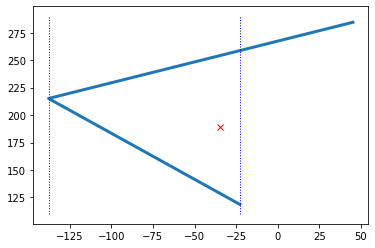

In [291]:
# Section 1
# if (section == 1):

# Randomly selecting X - Co-ordinates within Section 1
x_s1_p = np.random.randint(-137.70, -22.80, size=1).astype("float64")
# Randomly selecting X - Co-ordinates within Section 1
y_s1_p = np.random.randint( 118.67,  284.80, size=1).astype("float64")

# Plotting
x_s1 = [C_x, D_x, E_x]
y_s1 = [C_y, D_y, E_y]

# Plotting a scatter points 
plt.plot(x_s1_p, y_s1_p, 'x', color='red')

# Plotting lines acros points
plt.plot(x_s1, y_s1, linewidth=3)

# Plotting Section line-1 across point D 
plt.plot([D_x, D_x], [110, 290], linestyle='dotted', linewidth=1, color='blue')

# Plotting Section line-2 across point C
plt.plot([C_x, C_x], [110, 290], linestyle='dotted', linewidth=1, color='blue')

# Slope of point P and point C
m_pd = slope(C_x, C_y, x_s1_p, y_s1_p)
print("m_pd :", m_pc)

# Slope of line CD
m_cd = slope(C_x, C_y, D_x, D_y)
print("m_cd :", m_cd)

# Slope of line DE
m_de = slope(D_x, D_y, E_x, E_y)
print("m_de :", m_de)

# Slope of point P and point D
m_pd = slope(D_x, D_y, x_s1_p, y_s1_p)
print("m_pd :", m_pd)

#print("C : ", C_x, C_y)
#print("D : ", D_x, D_y)
#print("P : ", x_s1_p, y_s1_p)

if (m_pd > m_cd and m_pd < m_de):
    print("Yes It is inside the limits")
else:
    print("No it is outside the limits")

# Else if point is killed generate a new point and check the limits

y_s2_p :  [-4.] [195.]
m_cb : 0.08102533883323502
m_de : 0.3797185163305382
m_pc : 4.060106382978723
m_pd : -0.1502505422182335
Yes It is inside the limits


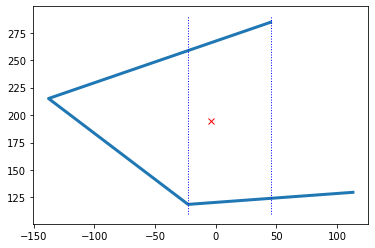

In [317]:
# Section 2

#if (section == 2):

# Randomly selecting X - Co-ordinates within Section 1
x_s2_p = np.random.randint(-22.80, 45.107, size=1).astype("float64")
# Randomly selecting X - Co-ordinates within Section 1
y_s2_p = np.random.randint( 118.67,  284.80, size=1).astype("float64")

print("y_s2_p : ", x_s2_p, y_s2_p)

# Plotting
x_s2 = [B_x, C_x, D_x, E_x]
y_s2 = [B_y, C_y, D_y, E_y]

# Plotting a scatter points 
plt.plot(x_s2_p, y_s2_p, 'x', color='red')

# Plotting lines acros points
plt.plot(x_s2, y_s2, linewidth=3)

# Plotting Section line-2 across point C
plt.plot([C_x, C_x], [110, 290], linestyle='dotted', linewidth=1, color='blue')

# Plotting Section line-3 across point E
plt.plot([E_x, E_x], [110, 290], linestyle='dotted', linewidth=1, color='blue')

# Slope of line CB
m_cb = slope(C_x, C_y, B_x, B_y)
print("m_cb :", m_cb)

# Slope of line DE
m_de = slope(D_x, D_y, E_x, E_y)
print("m_de :", m_de)

# Slope of point P and point C
m_pc = slope(C_x, C_y, x_s2_p, y_s2_p)
print("m_pc :", m_pc)

# Slope of point P and point D
m_pd = slope(D_x, D_y, x_s2_p, y_s2_p)
print("m_pd :", m_pd)

if (m_pc > m_cb and m_pd < m_de):
    print("Yes It is inside the limits")
else:
    print("No it is outside the limits")    

s3_p :  [-4.] [195.]
m_cb : 0.08102533883323502
m_fe : -0.1046496692569525
m_pc : 0.32097625329815305
m_pe : -17.928417585202077
Yes It is inside the limits


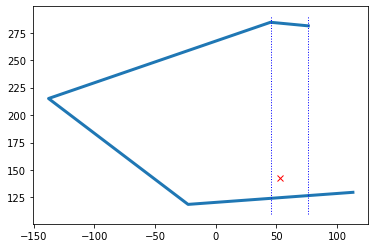

In [335]:
# Section 3

# Randomly selecting X - Co-ordinates within Section 3
x_s3_p = np.random.randint(45.107, 76.249, size=1).astype("float64")
# Randomly selecting X - Co-ordinates within Section 3
y_s3_p = np.random.randint( 118.67,  284.80, size=1).astype("float64")

print("s3_p : ", x_s3_p, y_s3_p)

# Plotting
x_s3 = [B_x, C_x, D_x, E_x, F_x]
y_s3 = [B_y, C_y, D_y, E_y, F_y]

# Plotting a scatter points 
plt.plot(x_s3_p, y_s3_p, 'x', color='red')

# Plotting lines acros points
plt.plot(x_s3, y_s3, linewidth=3)

# Plotting Section line-3 across point E
plt.plot([E_x, E_x], [110, 290], linestyle='dotted', linewidth=1, color='blue')

# Plotting Section line-4 across point F
plt.plot([F_x, F_x], [110, 290], linestyle='dotted', linewidth=1, color='blue')

# Slope of line CB
m_cb = slope(C_x, C_y, B_x, B_y)
print("m_cb :", m_cb)

# Slope of line FE
m_fe = slope(F_x, F_y, E_x, E_y)
print("m_fe :", m_fe)

# Slope of point P and point C
m_pc = slope(C_x, C_y, x_s3_p, y_s3_p)
print("m_pc :", m_pc)

# Slope of point P and point E
m_pe = slope(E_x, E_y, x_s3_p, y_s3_p)
print("m_pe :", m_pe)

if (m_pc > m_cb and m_pe < m_fe):
    print("Yes It is inside the limits")
else:
    print("No it is outside the limits")    

s4_p :  [103.] [128.]
m_cb : 0.08102533883323502
m_fa : -0.4256836528607643
m_pf : -5.728757803446599
m_pc : 0.07416534181240063
No it is outside the limits


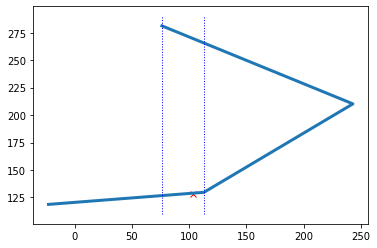

In [363]:
# Section 4

# Randomly selecting X - Co-ordinates within Section 4
x_s4_p = np.random.randint(76.249, 112.96, size=1).astype("float64")
# Randomly selecting X - Co-ordinates within Section 4
y_s4_p = np.random.randint( 118.67,  284.80, size=1).astype("float64")

print("s4_p : ", x_s4_p, y_s4_p)

# Plotting
x_s4 = [F_x, A_x, B_x, C_x]
y_s4 = [F_y, A_y, B_y, C_y]

# Plotting a scatter points 
plt.plot(x_s4_p, y_s4_p, 'x', color='red')

# Plotting lines acros points
plt.plot(x_s4, y_s4, linewidth=3)

# Plotting Section line-4 across point F
plt.plot([F_x, F_x], [110, 290], linestyle='dotted', linewidth=1, color='blue')

# Plotting Section line-5 across point B
plt.plot([B_x, B_x], [110, 290], linestyle='dotted', linewidth=1, color='blue')

# Slope of line CB
m_cb = slope(C_x, C_y, B_x, B_y)
print("m_cb :", m_cb)

# Slope of line FA
m_fa = slope(F_x, F_y, A_x, A_y)
print("m_fa :", m_fa)

# Slope of point P and point F
m_pf = slope(F_x, F_y, x_s4_p, y_s4_p)
print("m_pf :", m_pf)

# Slope of point P and point C
m_pc = slope(C_x, C_y, x_s4_p, y_s4_p)
print("m_pc :", m_pc)

if (m_pc > m_cb and m_pf < m_fa):
    print("Yes It is inside the limits")
else:
    print("No it is outside the limits")    

s5_p :  [127.] [159.]
m_ab : 0.61890126776796
m_fa : -0.4256836528607643
m_pf : -2.4088195306496423
m_pb : 2.089031339031339
Yes It is inside the limits


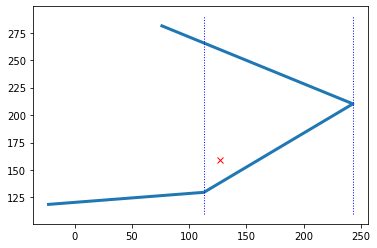

In [382]:
# Secion 5

# Randomly selecting X - Co-ordinates within Section 5
x_s5_p = np.random.randint(112.96, 243.11, size=1).astype("float64")
# Randomly selecting X - Co-ordinates within Section 5
y_s5_p = np.random.randint( 118.67,  284.80, size=1).astype("float64")

print("s5_p : ", x_s5_p, y_s5_p)

# Plotting
x_s5 = [F_x, A_x, B_x, C_x]
y_s5 = [F_y, A_y, B_y, C_y]

# Plotting a scatter points 
plt.plot(x_s5_p, y_s5_p, 'x', color='red')

# Plotting lines acros points
plt.plot(x_s5, y_s5, linewidth=3)


# Plotting Section line-5 across point B
plt.plot([B_x, B_x], [110, 290], linestyle='dotted', linewidth=1, color='blue')

# Plotting Section line-6 across point A
plt.plot([A_x, A_x], [110, 290], linestyle='dotted', linewidth=1, color='blue')

# Slope of line AB
m_ab = slope(A_x, A_y, B_x, B_y)
print("m_ab :", m_ab)

# Slope of line FA
m_fa = slope(F_x, F_y, A_x, A_y)
print("m_fa :", m_fa)

# Slope of point P and point F
m_pf = slope(F_x, F_y, x_s5_p, y_s5_p)
print("m_pf :", m_pf)

# Slope of point P and point B
m_pb = slope(B_x, B_y, x_s5_p, y_s5_p)
print("m_pb :", m_pb)

if (m_pf < m_fa and m_pb > m_ab):
    print("Yes It is inside the limits")
else:
    print("No it is outside the limits")   

x_g :  [94.]
y_g :  [209.]
Section - IV
m_cb : 0.08102533883323502
m_fa : -0.4256836528607643
m_gf : -4.070193228550503
m_gc : 0.7733732876712329
Yes It is inside the Section IV limits


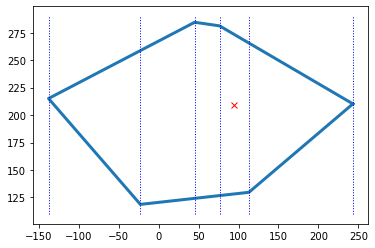

In [391]:
# Genrealized Goal function

# Randomly selecting X - Co-ordinates of goal within limits
x_g = np.random.randint(-137.71, 243.11, size=1).astype("float64")
print('x_g : ', x_g)

# Randomly selecting Y - Co-ordinates of goal within limits
y_g = np.random.randint(118.67, 284.80, size=1).astype("float64")
print('y_g : ', y_g)

# Splitting x and y
x = [A_x, B_x, C_x, D_x, E_x, F_x, A_x]
y = [A_y, B_y, C_y, D_y, E_y, F_y, A_y]

# Plotting lines acros points
plt.plot(x, y, linewidth=3)

# Plotting a scatter points 
plt.plot(x_g, y_g, 'x', color='red')

# Then sort it based on the section 
if (-137.70 < x_g < -22.80):
    section = 1
    print("Section - I")
elif (-22.80 <= x_g < 45.07):
    section = 2
    print("Section - II")
elif (45.07 <= x_g < 76.249):
    section = 3
    print("Section - III")
elif (76.249 <= x_g < 112.96):
    section = 4
    print("Section - IV")
elif (112.96 <= x_g < 243.11):
    section = 5
    print("Section - V")
else:
    print("Not in any section")
    
if (section == 1):

    # Slope of point G and point C
    m_gc = slope(C_x, C_y, x_g, y_g)
    print("m_gc :", m_gc)

    # Slope of line CD
    m_cd = slope(C_x, C_y, D_x, D_y)
    print("m_cd :", m_cd)

    # Slope of line DE
    m_de = slope(D_x, D_y, E_x, E_y)
    print("m_de :", m_de)

    # Slope of point G and point D
    m_gd = slope(D_x, D_y, x_g, y_g)
    print("m_gd :", m_gd)

    #print("C : ", C_x, C_y)
    #print("D : ", D_x, D_y)
    #print("P : ", x_g, y_g)

    if (m_gd > m_cd and m_gd < m_de):
        print("Yes It is inside the Section- I limits")
    else:
        print("No it is outside the Section- I limits")

elif (section == 2):

    # Slope of line CB
    m_cb = slope(C_x, C_y, B_x, B_y)
    print("m_cb :", m_cb)

    # Slope of line DE
    m_de = slope(D_x, D_y, E_x, E_y)
    print("m_de :", m_de)

    # Slope of point G and point C
    m_gc = slope(C_x, C_y, x_g, y_g)
    print("m_gc :", m_gc)

    # Slope of point G and point D
    m_gd = slope(D_x, D_y, x_g, y_g)
    print("m_gd :", m_gd)

    if (m_gc > m_cb and m_gd < m_de):
        print("Yes It is inside the Section- II limits")
    else:
        print("No it is outside the Section- II limits")    

elif (section == 3):
    # Slope of line CB
    m_cb = slope(C_x, C_y, B_x, B_y)
    print("m_cb :", m_cb)

    # Slope of line FE
    m_fe = slope(F_x, F_y, E_x, E_y)
    print("m_fe :", m_fe)

    # Slope of point G and point C
    m_gc = slope(C_x, C_y, x_g, y_g)
    print("m_gc :", m_gc)

    # Slope of point G and point E
    m_ge = slope(E_x, E_y, x_g, y_g)
    print("m_ge :", m_ge)

    if (m_gc > m_cb and m_ge < m_fe):
        print("Yes It is inside the Section III limits")
    else:
        print("No it is outside the Section III limits") 
    
elif (section == 4):
    # Slope of line CB
    m_cb = slope(C_x, C_y, B_x, B_y)
    print("m_cb :", m_cb)

    # Slope of line FA
    m_fa = slope(F_x, F_y, A_x, A_y)
    print("m_fa :", m_fa)

    # Slope of point G and point F
    m_gf = slope(F_x, F_y, x_g, y_g)
    print("m_gf :", m_gf)

    # Slope of point G and point C
    m_gc = slope(C_x, C_y, x_g, y_g)
    print("m_gc :", m_gc)

    if (m_gc > m_cb and m_gf < m_fa):
        print("Yes It is inside the Section IV limits")
    else:
        print("No it is outside the Section IV limits") 

elif (sectoin == 5):


# Plotting Section line-1 across point D 
plt.plot([D_x, D_x], [110, 290], linestyle='dotted', linewidth=1, color='blue')

# Plotting Section line-2 across point C
plt.plot([C_x, C_x], [110, 290], linestyle='dotted', linewidth=1, color='blue')

# Plotting Section line-3 across point E
plt.plot([E_x, E_x], [110, 290], linestyle='dotted', linewidth=1, color='blue')

# Plotting Section line-4 across point F
plt.plot([F_x, F_x], [110, 290], linestyle='dotted', linewidth=1, color='blue')

# Plotting Section line-5 across point B
plt.plot([B_x, B_x], [110, 290], linestyle='dotted', linewidth=1, color='blue')

# Plotting Section line-6 across point A
plt.plot([A_x, A_x], [110, 290], linestyle='dotted', linewidth=1, color='blue')

    